# Face tracking pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and tracking on an image dataset using MTCNN.

In [1]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

#### Determine if an nvidia GPU is available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Get a sample video

We begin by loading a video with some faces in it. The `mmcv` PyPI package by mmlabs is used to read the video frames (it can be installed with `pip install mmcv`). Frames are then converted to PIL images.

In [3]:
video_path = '../../tests/data/Elon Musk/sample_short.mp4'

display.Video(video_path, width=640)

## Run video through MTCNN

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

In [4]:
%%time

video_path = '../../tests/data/Elon Musk/sample_short.mp4'
video = mmcv.VideoReader(video_path)
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
arr = np.asarray([np.asarray(frame) for frame in frames])

CPU times: user 42.5 s, sys: 10.3 s, total: 52.8 s
Wall time: 26.6 s


## Batch frames

In [5]:
%%time 

mtcnn = MTCNN(keep_all=True, device=device)

batch_size = 30
batched_frames = np.array_split(arr, len(frames)//batch_size)

bboxes_found = []
for i, batch in enumerate(batched_frames):
    boxes, _ = mtcnn.detect(batch)
    bboxes_found += boxes.tolist()

CPU times: user 35.1 s, sys: 4.86 s, total: 39.9 s
Wall time: 40 s


## Draw Faces

In [14]:
%%time

frames_tracked = []
for i, frame in enumerate(frames):    
    
    boxes = bboxes_found[i]
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    
    if boxes is None:
        continue
    for box in boxes:
            draw.rectangle(box, outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))

CPU times: user 15.8 s, sys: 3.11 s, total: 18.9 s
Wall time: 18.8 s


## Display detections

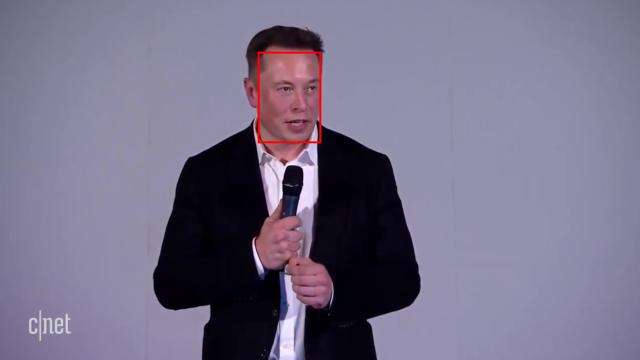

In [7]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

## Compare Speeds of different batch sizes

In [10]:
from time import time
import matplotlib.pyplot as plt

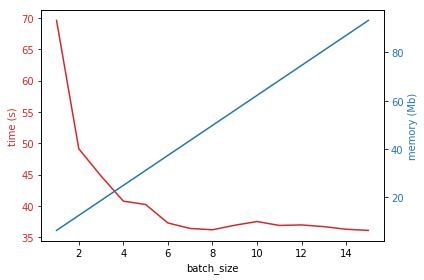

In [12]:
batch_sizes = range(1, 16)

mem_sizes = []
times = []

for batch_size in batch_sizes:
    start_time = time()
    
    batched_frames = np.array_split(arr, len(frames)//batch_size)

    bboxes_found = []
    for i, batch in enumerate(batched_frames):
        boxes, _ = mtcnn.detect(batch)
        bboxes_found += boxes.tolist()
        
    end_time = time()
    mem_sizes.append(batch.size * batch.itemsize /  1e+6)
    times.append(end_time - start_time)
    

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch_size')
ax1.set_ylabel('time (s)', color=color)
ax1.plot(batch_sizes, times, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('memory (Mb)', color=color)  # we already handled the x-label with ax1
ax2.plot(batch_sizes, mem_sizes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()